In [54]:
import numpy as np
import os
import pandas as pd
import time
import matplotlib.pyplot as plt

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules

In [71]:
# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # Windows 常用字體
# 若使用其他系統（如 macOS 或 Linux），可嘗試 'SimHei' 或下載其他中文字體
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

# Settings

In [4]:
dataDir = "./P1_Foodmart"
transaction_filename = "FoodMart-Transactions-1998.csv"
product_filename = "Product-Lookup.csv"
customer_filename = "Customer-Lookup.csv"

# Input and Data Preprocessing

## Data: transactions

In [5]:
# input: transactions
df_trans = pd.read_csv(os.path.join(dataDir,transaction_filename))

In [6]:
# 會返回一個包含兩個元素的元組 (rows, columns)
df_trans.shape

(182883, 6)

In [7]:
df_trans.head()

,transaction_date,stock_date,product_id,customer_id,store_id,quantity
0,1/1/1998,12/25/1997,4,2439,10,3
1,1/1/1998,12/28/1997,11,4284,10,3
2,1/1/1998,12/28/1997,12,534,10,3
3,1/1/1998,12/29/1997,14,9743,10,2
4,1/1/1998,12/27/1997,16,3608,10,3


In [8]:
df_trans["product_id"].value_counts()

product_id
382     157
277     155
284     151
274     150
865     149
       ... 
594      87
1249     87
113      83
1        59
1559     53
Name: count, Length: 1559, dtype: int64

In [9]:
df_trans["customer_id"].value_counts()

customer_id
1787    279
1259    236
7472    231
4386    226
4620    226
       ... 
9751      1
2157      1
6784      1
6336      1
3781      1
Name: count, Length: 8060, dtype: int64

### Data Transformation

In [10]:
trans_dataset = df_trans.groupby(["customer_id","transaction_date"])['product_id'].apply(list)

In [11]:
trans_dataset

customer_id  transaction_date
3            3/29/1998              [520, 672, 803, 986, 1056, 1063, 1418]
             4/17/1998                     [470, 670, 680, 747, 886, 1196]
6            1/16/1998                                           [75, 917]
             12/16/1998                             [701, 708, 1045, 1477]
             6/25/1998                               [391, 647, 997, 1506]
                                                   ...                    
10280        8/23/1998           [51, 404, 461, 571, 654, 910, 1153, 1386]
10281        1/7/1998                         [280, 949, 1066, 1299, 1395]
             6/23/1998                      [3, 313, 941, 962, 1145, 1345]
             7/17/1998           [209, 429, 519, 592, 708, 941, 945, 1111]
             8/1/1998                                    [519, 1001, 1112]
Name: product_id, Length: 37786, dtype: object

In [12]:
raw_transactions = list(trans_dataset)

In [13]:
print(len(raw_transactions))

37786


In [14]:
raw_transactions[:5]

[[520, 672, 803, 986, 1056, 1063, 1418],
 [470, 670, 680, 747, 886, 1196],
 [75, 917],
 [701, 708, 1045, 1477],
 [391, 647, 997, 1506]]

### Transaction encoding for Lib: mlxtend

In [15]:
te = TransactionEncoder()
te_trans = te.fit(raw_transactions).transform(raw_transactions)
# te.fix(raw_transactions) 分析 raw_transactions 中的所有唯一項目（產品 ID），並建立一個映射，將每個產品 ID 對應到一個列索引。
# .transform(raw_transactions)：將交易數據轉換為二進制矩陣，row數等於交易數量（37786），column數等於唯一產品數量（1559）。矩陣中的元素是 True（表示該產品出現在該交易中）或 False（表示該產品未出現）。

In [16]:
print(type(te_trans))
print(te_trans.shape)
te_trans

<class 'numpy.ndarray'>
(37786, 1559)


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [17]:
# product_id
te.columns_[:10]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

## Data: product

In [18]:
# input: products
df_prod = pd.read_csv(os.path.join(dataDir, product_filename))

In [19]:
df_prod.shape

(1560, 9)

In [20]:
df_prod.head()

,product_id,product_brand,product_name,product_sku,product_retail_price,product_cost,product_weight,recyclable,low_fat
0,1,Washington,Washington Berry Juice,90748583674,2.85,0.94,8.39,NaN,NaN
1,2,Washington,Washington Mango Drink,96516502499,0.74,0.26,7.42,NaN,1.0
2,3,Washington,Washington Strawberry Drink,58427771925,0.83,0.40,13.10,1.0,1.0
3,4,Washington,Washington Cream Soda,64412155747,3.64,1.64,10.60,1.0,NaN
4,5,Washington,Washington Diet Soda,85561191439,2.19,0.77,6.66,1.0,NaN


### Filtering

In [21]:
# 找出產品清單中定義但交易數據中未出現的產品 ID。
set(df_prod["product_id"].unique()).difference(set(te.columns_)) # 差集操作：返回 setA 中有但 setB 中沒有的元素。

{1560}

In [22]:
# 過濾 df_prod DataFrame，只保留那些 "product_id" 出現在 te.columns_ 中的行，並將結果重新賦值給 df_prod。
# 確保產品清單（df_prod）與交易數據中實際出現的產品（te.columns_）保持一致。
df_prod = df_prod[df_prod["product_id"].isin(te.columns_)] # 檢查 df_prod["product_id"] 中的每個值是否出現在 te.columns_ 中。

In [23]:
df_prod.shape

(1559, 9)

### Data preprocessing

In [24]:
df_te = pd.DataFrame(te_trans, columns = df_prod['product_name'])

In [25]:
print(df_te.shape)
df_te.head()

(37786, 1559)


product_name,Washington Berry Juice,Washington Mango Drink,Washington Strawberry Drink,Washington Cream Soda,Washington Diet Soda,Washington Cola,Washington Diet Cola,Washington Orange Juice,Washington Cranberry Juice,Washington Apple Juice,...,CDR Apple Butter,CDR Oregano,CDR Apple Jelly,CDR Grape Jam,CDR Apple Jam,CDR Strawberry Jam,CDR Creamy Peanut Butter,CDR Strawberry Preserves,CDR Extra Chunky Peanut Butter,CDR Apple Preserves
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Association Analysis

## Threshold setting

In [26]:
min_sup = 0.00015
min_conf = 0.8

In [27]:
support_count = min_sup * df_te.shape[0]
print(support_count)

5.6678999999999995


## Frequent pattern/itemset discovering

In [28]:
# 測量 Apriori 執行所需的時間
start_time = time.time()
frequent_itemsets = fpgrowth(df_te, min_support = min_sup, use_colnames = True)
end_time = time.time()
print(str(end_time - start_time) + " seconds")

208.44927954673767 seconds


In [29]:
frequent_itemsets.sort_values(by=["support"], ascending = False)

,support,itemsets
954,0.004155,(Moms Roasted Chicken)
796,0.004102,(Great English Muffins)
861,0.003996,(Super Chunky Peanut Butter)
1013,0.003970,(Great Pumpernickel Bread)
1401,0.003943,(Nationeel Dried Apples)
...,...,...
2145,0.000159,"(Golden Chicken TV Dinner, Just Right Fancy Ca..."
2144,0.000159,"(Fort West Golden Raisins, Sphinx Cranberry Mu..."
2143,0.000159,"(Hilltop Dishwasher Detergent, Cormorant Fryin..."
2142,0.000159,"(Cormorant Frying Pan, Denny Frying Pan)"


## Association rule discovering

### 列出 Lift 最高的前10條 Rules

In [30]:
# 列出 Lift 最高的前10條 Rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_conf).sort_values(by='lift', ascending=False)

In [31]:
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
10,"(Just Right Canned Yams, Hilltop 200 MG Acetom...",(Faux Products HCL Nasal Spray),0.000159,0.002964,0.000159,1.000000,337.375000,1.0,0.000158,inf,0.997194,0.053571,1.000000,0.526786
1,"(CDR Hot Chocolate, Imagine Low Fat French Fries)",(Quick Extra Lean Hamburger),0.000185,0.003123,0.000185,1.000000,320.220339,1.0,0.000185,inf,0.997062,0.059322,1.000000,0.529661
6,"(Booker Low Fat String Cheese, Bravo Fancy Can...",(High Top Oranges),0.000159,0.003202,0.000159,1.000000,312.280992,1.0,0.000158,inf,0.996956,0.049587,1.000000,0.524793
13,"(High Quality Scissors, Plato French Roast Cof...",(Dollar Monthly Sports Magazine),0.000159,0.003202,0.000159,1.000000,312.280992,1.0,0.000158,inf,0.996956,0.049587,1.000000,0.524793
15,"(Cormorant Scented Toilet Tissue, Hilltop 200 ...",(Horatio No Salt Popcorn),0.000159,0.003335,0.000159,1.000000,299.888889,1.0,0.000158,inf,0.996824,0.047619,1.000000,0.523810
0,"(CDR Hot Chocolate, Quick Extra Lean Hamburger)",(Imagine Low Fat French Fries),0.000212,0.002991,0.000185,0.875000,292.590708,1.0,0.000185,7.976076,0.996793,0.061404,0.874625,0.468473
8,"(Imagine Frozen Cheese Pizza, BBB Best Tomato ...",(Best Choice Apple Fruit Roll),0.000185,0.002938,0.000159,0.857143,291.783784,1.0,0.000158,6.979437,0.996757,0.053571,0.856722,0.455598
2,"(High Top New Potatos, Even Better Sharp Chedd...",(High Top Summer Squash),0.000185,0.003070,0.000159,0.857143,279.206897,1.0,0.000158,6.978511,0.996603,0.051282,0.856703,0.454433
4,"(High Top Summer Squash, Even Better Sharp Che...",(High Top New Potatos),0.000159,0.003732,0.000159,1.000000,267.985816,1.0,0.000158,inf,0.996427,0.042553,1.000000,0.521277
12,"(Dollar Monthly Sports Magazine, Plato French ...",(High Quality Scissors),0.000185,0.003229,0.000159,0.857143,265.475410,1.0,0.000158,6.977399,0.996418,0.048780,0.856680,0.453162


### 列出 Confidence 最高的前10條 Rules

In [32]:
# 列出 Confidence 最高的前10條 Rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_conf).sort_values(by='confidence', ascending=False)

In [33]:
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
10,"(Just Right Canned Yams, Hilltop 200 MG Acetom...",(Faux Products HCL Nasal Spray),0.000159,0.002964,0.000159,1.000000,337.375000,1.0,0.000158,inf,0.997194,0.053571,1.000000,0.526786
15,"(Cormorant Scented Toilet Tissue, Hilltop 200 ...",(Horatio No Salt Popcorn),0.000159,0.003335,0.000159,1.000000,299.888889,1.0,0.000158,inf,0.996824,0.047619,1.000000,0.523810
4,"(High Top Summer Squash, Even Better Sharp Che...",(High Top New Potatos),0.000159,0.003732,0.000159,1.000000,267.985816,1.0,0.000158,inf,0.996427,0.042553,1.000000,0.521277
13,"(High Quality Scissors, Plato French Roast Cof...",(Dollar Monthly Sports Magazine),0.000159,0.003202,0.000159,1.000000,312.280992,1.0,0.000158,inf,0.996956,0.049587,1.000000,0.524793
6,"(Booker Low Fat String Cheese, Bravo Fancy Can...",(High Top Oranges),0.000159,0.003202,0.000159,1.000000,312.280992,1.0,0.000158,inf,0.996956,0.049587,1.000000,0.524793
1,"(CDR Hot Chocolate, Imagine Low Fat French Fries)",(Quick Extra Lean Hamburger),0.000185,0.003123,0.000185,1.000000,320.220339,1.0,0.000185,inf,0.997062,0.059322,1.000000,0.529661
0,"(CDR Hot Chocolate, Quick Extra Lean Hamburger)",(Imagine Low Fat French Fries),0.000212,0.002991,0.000185,0.875000,292.590708,1.0,0.000185,7.976076,0.996793,0.061404,0.874625,0.468473
14,"(Cormorant Scented Toilet Tissue, Horatio No S...",(Hilltop 200 MG Acetominifen),0.000185,0.003520,0.000159,0.857143,243.518797,1.0,0.000158,6.975361,0.996078,0.044776,0.856638,0.451128
12,"(Dollar Monthly Sports Magazine, Plato French ...",(High Quality Scissors),0.000185,0.003229,0.000159,0.857143,265.475410,1.0,0.000158,6.977399,0.996418,0.048780,0.856680,0.453162
11,"(Dollar Monthly Sports Magazine, High Quality ...",(Plato French Roast Coffee),0.000185,0.003282,0.000159,0.857143,261.193548,1.0,0.000158,6.977029,0.996356,0.048000,0.856673,0.452765


# Customers

In [34]:
df_cust = pd.read_csv(os.path.join(dataDir,customer_filename))

In [35]:
df_cust.shape

(10281, 20)

In [36]:
df_cust.tail()

,customer_id,customer_acct_num,first_name,last_name,customer_address,customer_city,customer_state_province,customer_postal_code,customer_country,birthdate,marital_status,yearly_income,gender,total_children,num_children_at_home,education,acct_open_date,member_card,occupation,homeowner
10276,10277,87439274191,Fran,Ross,5603 Blackridge Drive,Lake Oswego,OR,52724,USA,2/9/1974,M,$90K - $110K,M,4,3,Partial High School,3/14/1991,Bronze,Management,N
10277,10278,87448420500,Myreda,Calahoo,263 La Orinda Pl.,N. Vancouver,BC,71758,Canada,12/8/1926,M,$30K - $50K,F,0,0,Partial College,3/20/1992,Bronze,Professional,N
10278,10279,87453135848,Mary,Ayers,6885 Auburn,Lincoln Acres,CA,42550,USA,5/18/1913,S,$130K - $150K,M,3,0,Partial High School,11/22/1991,Bronze,Management,Y
10279,10280,87458639740,Ernest,Aiello,5077 Bannock Ct.,Puyallup,WA,27746,USA,9/6/1968,M,$150K +,F,5,2,High School Degree,5/26/1991,Golden,Professional,Y
10280,10281,87460163235,Samuel,Cartney,4609 Parkway Drive,Vancouver,BC,63699,Canada,7/6/1914,S,$50K - $70K,F,5,0,Bachelors Degree,7/22/1993,Bronze,Management,N


In [37]:
# 選擇指定的屬性
selected_columns = [
    'customer_state_province', 'yearly_income', 'gender', 
    'total_children', 'num_children_at_home', 'education', 
    'occupation', 'homeowner'
]

df_selected = df_cust[selected_columns]

In [38]:
# 將每個屬性值轉換為 "屬性=值" 的形式，作為交易項目
transactions = []
for _, row in df_selected.iterrows(): # iterrows() 方法返回 DataFrame 中的每一行，並將索引和行數據作為一個 Series 對象返回。
    transaction = []
    for col in selected_columns:
        transaction.append(f"{col}={row[col]}")
    transactions.append(transaction)

In [39]:
# 使用 TransactionEncoder 將交易數據轉為二進制矩陣
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_te = pd.DataFrame(te_ary, columns=te.columns_)

In [40]:
# 設置最小支持度和置信度
min_support = 0.05
min_confidence = 0.9

In [41]:
# 使用 Apriori 算法挖掘頻繁項集
frequent_itemsets = apriori(df_te, min_support=min_support, use_colnames=True)

In [42]:
# 挖掘關聯規則
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

In [43]:
# 按 lift 排序並選擇前 10 條規則
rules_sorted = rules.sort_values(by='lift', ascending=False).head(10)

print("\n前 10 條關聯規則（按 Lift 排序）：")
formatted_rules = rules_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']].copy()
formatted_rules['antecedents'] = formatted_rules['antecedents'].apply(lambda x: ', '.join(list(x)))
formatted_rules['consequents'] = formatted_rules['consequents'].apply(lambda x: ', '.join(list(x)))
formatted_rules['support'] = formatted_rules['support'].apply(lambda x: f"{x:.3f}")
formatted_rules['confidence'] = formatted_rules['confidence'].apply(lambda x: f"{x:.2f}")
formatted_rules['lift'] = formatted_rules['lift'].apply(lambda x: f"{x:.2f}")

print(formatted_rules.to_string(index=False))


前 10 條關聯規則（按 Lift 排序）：
                                                                 antecedents                   consequents support confidence lift
                          yearly_income=$50K - $70K, occupation=Professional    education=Bachelors Degree   0.097       0.95 3.73
             yearly_income=$50K - $70K, homeowner=Y, occupation=Professional    education=Bachelors Degree   0.054       0.95 3.71
  yearly_income=$50K - $70K, occupation=Professional, num_children_at_home=0    education=Bachelors Degree   0.063       0.94 3.70
        yearly_income=$10K - $30K, num_children_at_home=0, occupation=Manual education=Partial High School   0.065       0.97 3.22
                   occupation=Manual, homeowner=Y, yearly_income=$10K - $30K education=Partial High School   0.060       0.97 3.22
                      occupation=Manual, yearly_income=$10K - $30K, gender=F education=Partial High School   0.050       0.97 3.22
                                occupation=Manual, yearly_i

In [44]:
# 讀取數據
df_trans = pd.read_csv(os.path.join(dataDir, transaction_filename))
df_prod = pd.read_csv(os.path.join(dataDir, product_filename))
df_cust = pd.read_csv(os.path.join(dataDir, customer_filename))

In [45]:
# 將 transaction_date 轉為日期格式並提取月份
df_trans['transaction_date'] = pd.to_datetime(df_trans['transaction_date'])
df_trans['month'] = df_trans['transaction_date'].dt.month

In [46]:
# 分割 12 月與 1-11 月的交易數據
df_dec = df_trans[df_trans['month'] == 12]
df_jan_nov = df_trans[df_trans['month'] != 12]

In [47]:
# 合併交易數據與產品和顧客信息
df_dec = df_dec.merge(df_prod[['product_id', 'product_name']], on='product_id', how='left')
df_jan_nov = df_jan_nov.merge(df_prod[['product_id', 'product_name']], on='product_id', how='left')
df_dec = df_dec.merge(df_cust[['customer_id', 'customer_state_province', 'yearly_income']], on='customer_id', how='left')
df_jan_nov = df_jan_nov.merge(df_cust[['customer_id', 'customer_state_province', 'yearly_income']], on='customer_id', how='left')

In [76]:
# 1. 交易數量比較
dec_trans_count = len(df_dec)
jan_nov_trans_count = len(df_jan_nov)
jan_nov_trans_count_avg = jan_nov_trans_count / 11
print(f"12 月交易數量: {dec_trans_count}")
print(f"1-11 月平均交易數量: {jan_nov_trans_count_avg:.2f}")
print(f"12 月交易占比: {dec_trans_count / (dec_trans_count + jan_nov_trans_count):.2%}")

12 月交易數量: 18325
1-11 月平均交易數量: 14959.82
12 月交易占比: 10.02%


In [82]:
# 2. 熱門產品比較
dec_top_products = df_dec['product_name'].value_counts().head(10)
jan_nov_top_products = df_jan_nov['product_name'].value_counts().head(10)
jan_nov_top_products_avg = jan_nov_top_products / 11  # 將 1-11 月總數除以 11 取平均
print("\n12 月熱門產品 (前 10):")
print(dec_top_products)
print("\n1-11 月熱門產品 (前 10):")
print(jan_nov_top_products_avg.round(2))


12 月熱門產品 (前 10):
product_name
Hilltop 200 MG Ibuprofen            25
American Sliced Ham                 23
Booker Low Fat Cottage Cheese       23
Super Grape Jam                     23
Moms Roasted Chicken                22
Landslide Vegetable Oil             22
Urban Large Eggs                    21
Sunset 75 Watt Lightbulb            21
Hermanos Limes                      21
Top Measure White Zinfandel Wine    21
Name: count, dtype: int64

1-11 月熱門產品 (前 10):
product_name
Great English Muffins           13.00
Carrington Ice Cream            12.73
Nationeel Dried Apples          12.55
Nationeel Fudge Brownies        12.55
Ebony Mixed Nuts                12.45
Excellent Orange Juice          12.45
Booker String Cheese            12.45
Steady Childrens Cold Remedy    12.36
Moms Roasted Chicken            12.27
Super Chunky Peanut Butter      12.18
Name: count, dtype: float64


In [83]:
# 3. 顧客屬性分析：收入分佈
dec_income_dist = df_dec['yearly_income'].value_counts(normalize=True).sort_values(ascending=False)
jan_nov_income_dist = df_jan_nov['yearly_income'].value_counts(normalize=True).sort_values(ascending=False)
print("\n12 月顧客收入分佈:")
print(dec_income_dist.round(2))
print("\n1-11 月顧客收入分佈:")
print(jan_nov_income_dist.round(2))


12 月顧客收入分佈:
yearly_income
$30K - $50K      0.34
$10K - $30K      0.22
$50K - $70K      0.16
$70K - $90K      0.12
$130K - $150K    0.05
$90K - $110K     0.05
$110K - $130K    0.04
$150K +          0.02
Name: proportion, dtype: float64

1-11 月顧客收入分佈:
yearly_income
$30K - $50K      0.33
$10K - $30K      0.22
$50K - $70K      0.17
$70K - $90K      0.12
$130K - $150K    0.05
$110K - $130K    0.05
$90K - $110K     0.04
$150K +          0.02
Name: proportion, dtype: float64


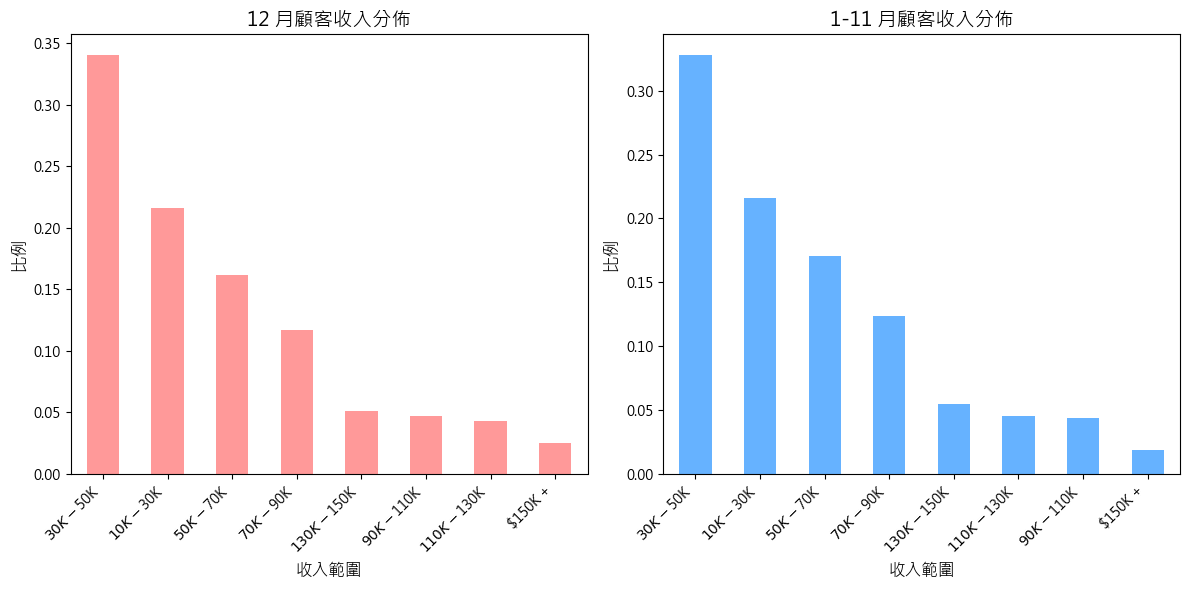

In [84]:
# 圖表 3: 顧客收入分佈 (柱狀圖)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
dec_income_dist.plot(kind='bar', color='#FF9999')
plt.title('12 月顧客收入分佈', fontsize=14)
plt.xlabel('收入範圍', fontsize=12)
plt.ylabel('比例', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
jan_nov_income_dist.plot(kind='bar', color='#66B2FF')
plt.title('1-11 月顧客收入分佈', fontsize=14)
plt.xlabel('收入範圍', fontsize=12)
plt.ylabel('比例', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [85]:
# 4. 地區購物行為比較
dec_state_dist = df_dec['customer_state_province'].value_counts(normalize=True).head(10)
jan_nov_state_dist = df_jan_nov['customer_state_province'].value_counts(normalize=True).head(10)
print("\n12 月顧客地區分佈 (前10):")
print(dec_state_dist.round(2))
print("\n1-11 月顧客地區分佈 (前10):")
print(jan_nov_state_dist.round(2))


12 月顧客地區分佈 (前10):
customer_state_province
WA           0.26
CA           0.14
Zacatecas    0.13
OR           0.12
BC           0.08
DF           0.07
Yucatan      0.07
Veracruz     0.05
Guerrero     0.03
Sinaloa      0.03
Name: proportion, dtype: float64

1-11 月顧客地區分佈 (前10):
customer_state_province
WA           0.25
CA           0.14
Zacatecas    0.14
OR           0.12
BC           0.09
Yucatan      0.07
DF           0.07
Veracruz     0.05
Guerrero     0.03
Mexico       0.02
Name: proportion, dtype: float64


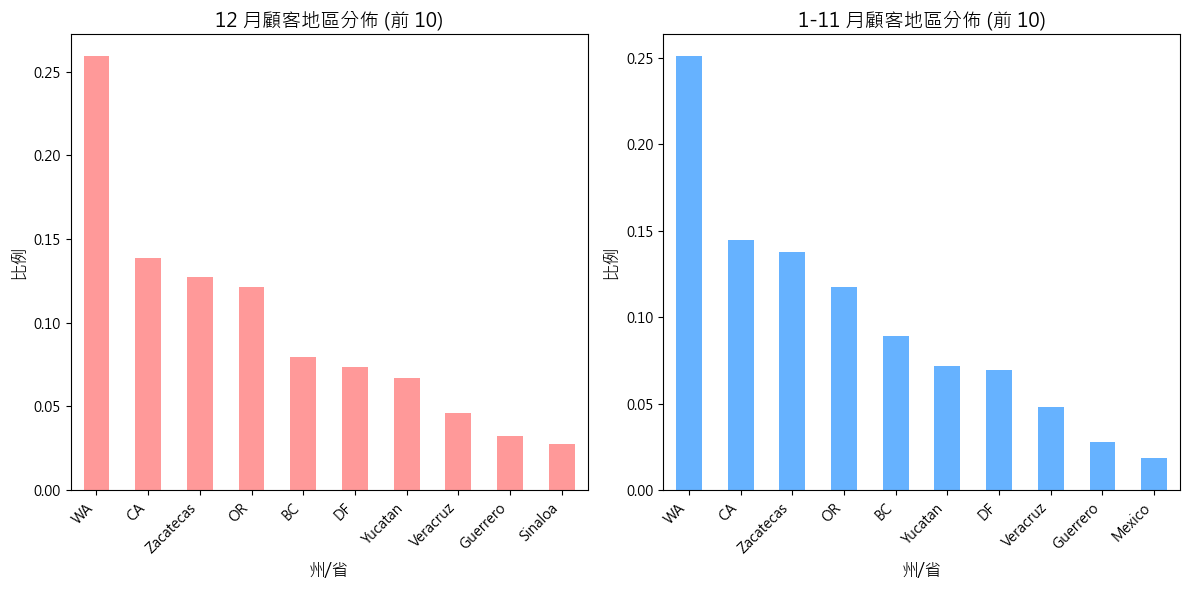

In [86]:
# 圖表 4: 顧客地區分佈 (柱狀圖)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
dec_state_dist.plot(kind='bar', color='#FF9999')
plt.title('12 月顧客地區分佈 (前 10)', fontsize=14)
plt.xlabel('州/省', fontsize=12)
plt.ylabel('比例', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
jan_nov_state_dist.plot(kind='bar', color='#66B2FF')
plt.title('1-11 月顧客地區分佈 (前 10)', fontsize=14)
plt.xlabel('州/省', fontsize=12)
plt.ylabel('比例', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

12 月顧客數量: 2689
  一次性顧客 (1 次): 1929, 比例: 71.74%
  復購顧客 (>1 次): 760, 比例: 28.26%
1-11 月顧客數量: 7824
  一次性顧客 (平均 ≤ 1 次): 7259, 比例: 92.78%
  復購顧客 (平均 > 1 次): 565, 比例: 7.22%


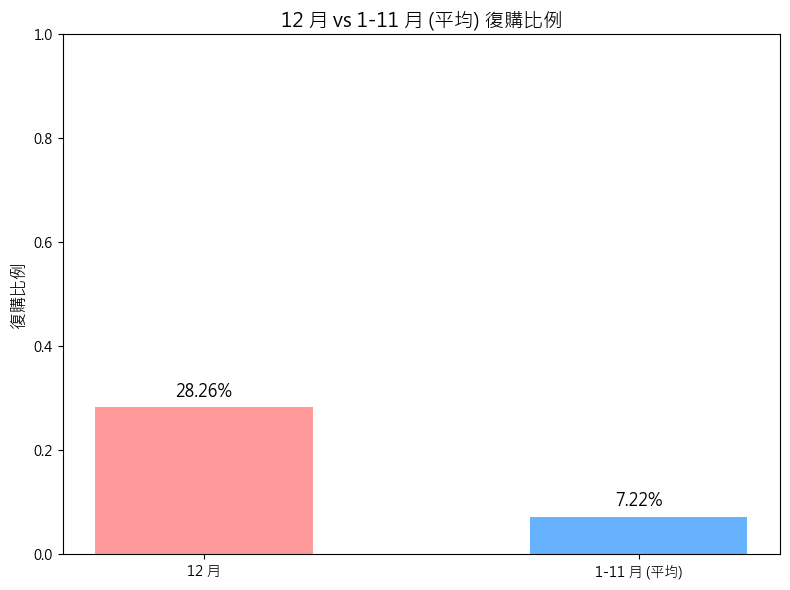

In [93]:
# 5. 交易頻次分析

# 按 customer_id 和 transaction_date 分組，計算每位顧客的獨立交易次數
dec_customer_trans = df_dec.groupby('customer_id')['transaction_date'].nunique().reset_index()
dec_customer_trans.columns = ['customer_id', 'transaction_count']

# 1-11 月交易次數取平均（除以 11 個月）
jan_nov_customer_trans = df_jan_nov.groupby('customer_id')['transaction_date'].nunique().reset_index()
jan_nov_customer_trans.columns = ['customer_id', 'transaction_count']
jan_nov_customer_trans['transaction_count'] = (jan_nov_customer_trans['transaction_count'] / 11).round(2)  # 平均並保留小數點後兩位

# 分類一次性顧客（≤1 次）與復購顧客（>1 次）
# 對於 1-11 月平均值，1 次意味著平均每月交易 ≤ 1 次
dec_once = len(dec_customer_trans[dec_customer_trans['transaction_count'] == 1])
dec_repeat = len(dec_customer_trans[dec_customer_trans['transaction_count'] > 1])
jan_nov_once = len(jan_nov_customer_trans[jan_nov_customer_trans['transaction_count'] <= 1])
jan_nov_repeat = len(jan_nov_customer_trans[jan_nov_customer_trans['transaction_count'] > 1])

# 計算復購比例
dec_total_customers = dec_once + dec_repeat
jan_nov_total_customers = jan_nov_once + jan_nov_repeat
dec_repeat_ratio = dec_repeat / dec_total_customers if dec_total_customers > 0 else 0
jan_nov_repeat_ratio = jan_nov_repeat / jan_nov_total_customers if jan_nov_total_customers > 0 else 0

# 輸出結果
print(f"12 月顧客數量: {dec_total_customers}")
print(f"  一次性顧客 (1 次): {dec_once}, 比例: {dec_once / dec_total_customers:.2%}")
print(f"  復購顧客 (>1 次): {dec_repeat}, 比例: {dec_repeat_ratio:.2%}")
print(f"1-11 月顧客數量: {jan_nov_total_customers}")
print(f"  一次性顧客 (平均 ≤ 1 次): {jan_nov_once}, 比例: {jan_nov_once / jan_nov_total_customers:.2%}")
print(f"  復購顧客 (平均 > 1 次): {jan_nov_repeat}, 比例: {jan_nov_repeat_ratio:.2%}")

# 圖表 5: 復購比例柱狀圖
plt.figure(figsize=(8, 6))
plt.bar(['12 月', '1-11 月 (平均)'], [dec_repeat_ratio, jan_nov_repeat_ratio], 
        color=['#FF9999', '#66B2FF'], width=0.5)
plt.title('12 月 vs 1-11 月 (平均) 復購比例', fontsize=14)
plt.ylabel('復購比例', fontsize=12)
plt.ylim(0, 1)
for i, v in enumerate([dec_repeat_ratio, jan_nov_repeat_ratio]):
    plt.text(i, v + 0.02, f'{v:.2%}', ha='center', fontsize=12)
plt.tight_layout()
plt.show()